# Credit Card Default Demo

In [43]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method
from core import recourse_iterator
from data import data_loader
from data.adapters import continuous_adapter
from core import utils
from visualize.two_d_plots import Display2DPaths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data and model

In [44]:
dataset, dataset_info = data_loader.load_data(data_loader.DatasetName.CREDIT_CARD_DEFAULT)
adapter = continuous_adapter.StandardizingAdapter(label_name=dataset_info.label_name, positive_label=dataset_info.positive_label).fit(dataset)
dataset

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,689,0,0,0,0,1
2,120000,26,0,2,0,0,0,2,2682,1725,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,43,0,0,0,0,0,0,1683,1828,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,37,4,3,2,0,0,0,3565,3356,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


Accuracy:  0.8186333333333333


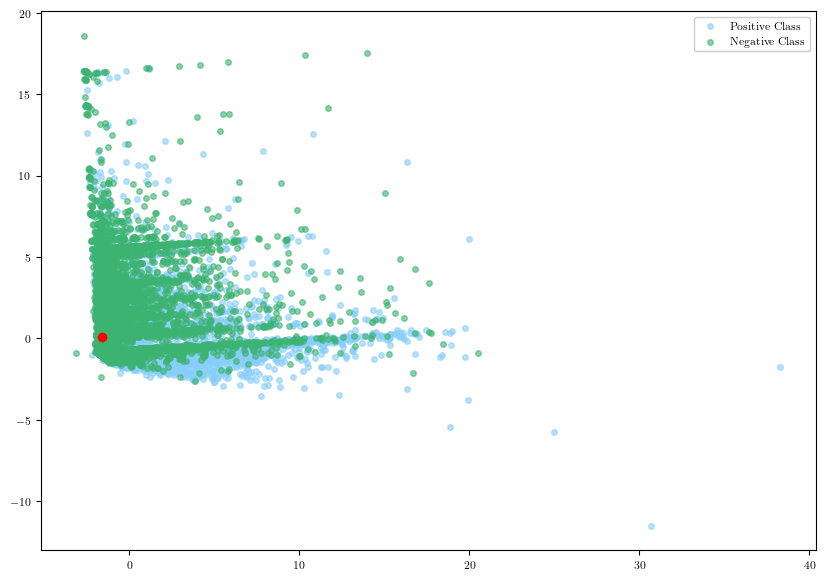

In [45]:
embedded_dataset = adapter.transform(dataset)
X = embedded_dataset.drop(dataset_info.label_name, axis=1)
y = embedded_dataset[dataset_info.label_name]

model = linear_model.LogisticRegression(penalty='none')
model.fit(X, y)

y_pred = model.predict(X)

print("Accuracy: ", (y == y_pred).sum() / y.size)

poi = utils.random_poi(dataset, column='Y', label=adapter.negative_label)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label = dataset_info.positive_label,
).set_poi(adapter.transform_series(poi)).do_pca().scatter()

## Generate some recourse directions

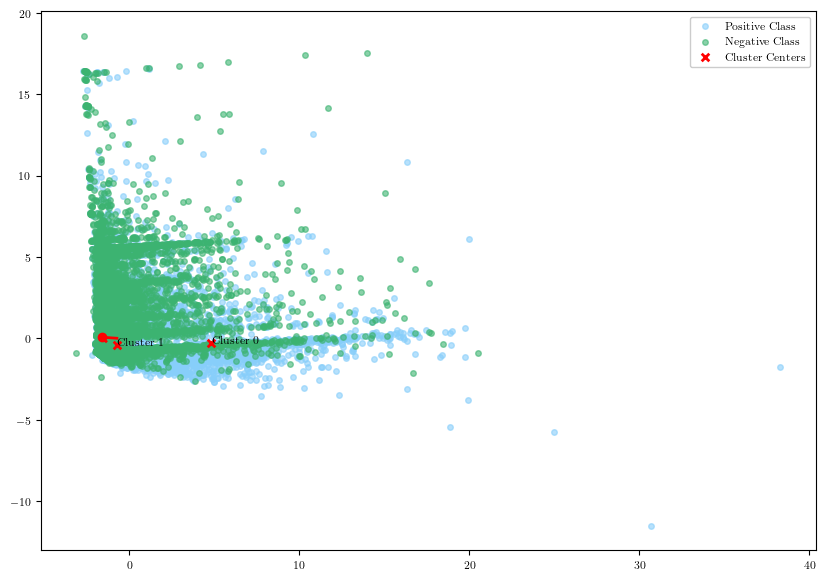

In [48]:
k_directions = 2
mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))
poix = adapter.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label,
).do_pca().set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths

/home/jakeval/umass/research/.env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/jakeval/umass/research/.env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/jakeval/umass/research/.env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/jakeval/umass/research/.env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


final certainty for path 0: 1.0
final certainty for path 1: 1.0


(<Figure size 1000x700 with 1 Axes>, <AxesSubplot:>)

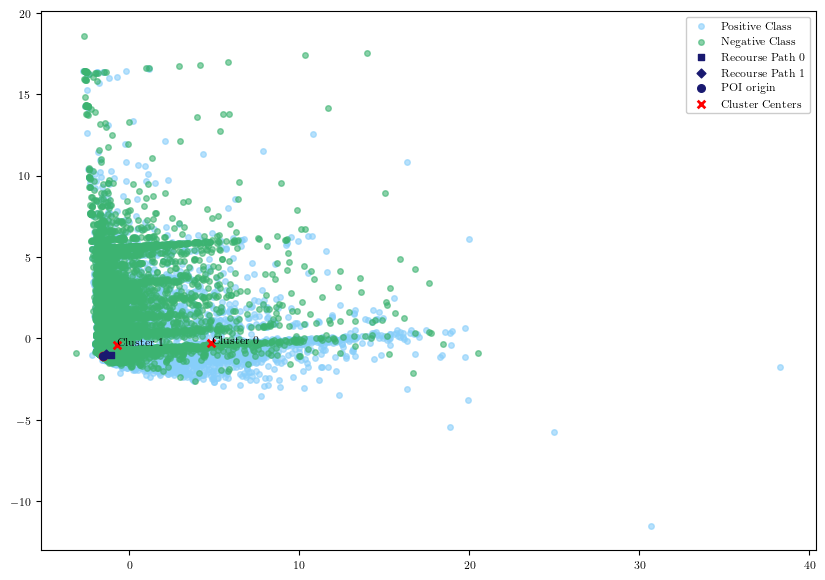

In [71]:
check_certainty = recourse_iterator.wrap_model(model, positive_index=1)

mrmc = mrmc_method.MRMC(
    k_directions,
    adapter,
    dataset,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.5))

display = Display2DPaths(
    adapter.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=dataset_info.positive_label
)

poi = utils.random_poi(dataset, column='Y', label = 1)

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    adapter,
    certainty_cutoff=0.5,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {check_certainty(path.iloc[-1])}')

transformed_paths = [adapter.transform(path) for path in paths]

display.do_pca().set_poi(adapter.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).scatter()

## What features are changed?

In [72]:
paths[0]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,280000.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,787.000000,1233.000000,0.000000,0.000000,0.00000,787.000000,1233.000000,0.000000,0.000000
1,276737.853596,31.467371,0.008235,0.008028,0.008222,0.007125,0.006364,0.007387,14741.469898,14325.538683,13808.821346,13498.913857,12984.230422,11438.695071,968.412365,997.42363,1524.897285,1856.674898,743.975309,722.538838


In [73]:
paths[1]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,280000.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,787.000000,1233.000000,0.00000,0.00000,0.000000,787.000000,1233.000000,0.000000,0.000000
1,233118.634533,32.366236,0.045504,0.016923,0.017833,0.012372,0.0087,0.011229,9013.958726,7611.477678,7009.896953,6498.352538,6035.172329,5297.22626,1683.42051,1782.021921,1776.021898,1711.235771,1302.989718,1369.234896
